In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle, os
import pandas as pd
from tqdm import tqdm 

## Load Important Function

In [2]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

In [3]:
def omega2cistrans(omega):
    """Converts a sequence of float omega angles (in degrees) to an array of ints: 0 cis and 1 trans."""
    
    shifted_omega = (omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    cistrans = np.where(shifted_omega > 90.0, 1, 0).astype(int)
    return cistrans

In [4]:
def state_to_index_vectorized(all_state):
    """
    Converts a (N, M, 2) array of states into (N, M) indices in [0..7].

    Assumes:
      - The first entry is a binary bit (0 or 1).
      - The second entry is an integer in [0..3].
      - If any of the two entries is NaN, the output is NaN for that row.

    Parameters
    ----------
    all_state : array-like
        An array of shape (N, M, 2).

    Returns
    -------
    indexed_states : ndarray
        A float array of shape (N, M). Valid entries are in the range [0..7].
        Entries with NaNs in the input remain NaN.
    """
    all_state_array = np.array(all_state, dtype=float)

    if all_state_array.ndim != 3 or all_state_array.shape[-1] != 2:
        raise ValueError(f"Unexpected shape: {all_state_array.shape}, expected (N, M, 2).")

    # NaN handling
    nan_mask = np.isnan(all_state_array).any(axis=-1)
    valid_mask = ~nan_mask

    # Prepare output
    indexed_states = np.full(all_state_array.shape[:-1], np.nan, dtype=float)

    # Compute index: 4 * binary_bit + discrete_value
    weights = np.array([4, 1], dtype=float)
    valid_data = all_state_array[valid_mask]
    results = valid_data @ weights

    indexed_states[valid_mask] = results

    return indexed_states

In [5]:
def index_to_state(index):
    """
    Converts an index (0-7) into a (2,) array:
      - The first element is a binary bit (0 or 1)
      - The second element is an integer in [0..3]

    This reverses the mapping from:
        index = 4 * binary_bit + value_in_0_to_3

    Parameters
    ----------
    index : int
        Integer in [0, 7]

    Returns
    -------
    state : np.ndarray
        Array of shape (2,) — [binary_bit, value]
    """
    if not (0 <= index < 8):
        raise ValueError(f"Index out of range: {index}. Expected 0–7.")

    value = index % 4
    binary_bit = index // 4

    return np.array([binary_bit, value], dtype=int)


In [6]:
import numpy as np
from tqdm import tqdm

def calculate_conform_p(trajs, conform_num):
    """
    Calculates the cumulative average population of each conformational state over time,
    excluding NaN values in the trajectory.

    Parameters
    ----------
    trajs : np.ndarray
        A 1D array of shape (timesteps,), where each value is either an integer in 
        [0, conform_num-1] or NaN (for missing data).

    conform_num : int
        The total number of conformational states.

    Returns
    -------
    conform_population : np.ndarray
        Array of shape (conform_num, valid_timesteps) — cumulative average population per conformation.
    """
    trajs = np.asarray(trajs)

    # Only keep valid time steps (non-NaN)
    valid_mask = ~np.isnan(trajs)
    trajs_clean = trajs[valid_mask]
    n_time = trajs_clean.shape[0]

    conform_population = np.zeros((conform_num, n_time), dtype=float)

    for conform_state in range(conform_num):
        match_mask = (trajs_clean == conform_state).astype(float)  # shape: (n_time,)

        cumulative_counts = np.cumsum(match_mask)  # shape: (n_time,)
        time_steps = np.arange(1, n_time + 1)      # shape: (n_time,)

        cumulative_proportions = cumulative_counts / time_steps  # shape: (n_time,)
        conform_population[conform_state] = cumulative_proportions

    #print('Conform population shape:', conform_population.shape)

    return conform_population


## The Trans Population overtime Plot

In [7]:
save_dir = 'omega_data'
all_omega = Data.load(f"{save_dir}/all_omega.pkl").array_list  # This is an (85, x, 3) array
# Convert each array in the list to float
all_omega = [arr.astype(float) for arr in all_omega]

# Apply omega2cistrans() to each array in all_omega
all_cistrans = [omega2cistrans(arr) for arr in all_omega]

# Print shape of the first converted array for verification
print(f"First array shape after conversion: {all_cistrans[0].shape}")

First array shape after conversion: (206002, 3)


In [8]:
# Find the minimum x-dimension across all arrays
min_x = min(arr.shape[0] for arr in all_cistrans)

print(f"Shortest x in all_cistrans: {min_x}")

Shortest x in all_cistrans: 171002


In [9]:
# Define paths
traj_path = '../PROJ12462traj'
log_path = '../log'

all_state = []

# Iterate over RUN and CLONE indices
for r in range(2, 3):  # Only r=2 for now
    for c in range(100):  # Iterate over c=0 to c=99
        csv_log = f"{log_path}/RUN{r}_CLONE{c}_log.csv"
        input_xtc_file = f"{traj_path}/r{r}c{c}_inte.xtc"

        # Corrected condition: Check if either file is missing
        if not os.path.exists(csv_log) or not os.path.exists(input_xtc_file):
            print(f"Missing file(s): {input_xtc_file if not os.path.exists(input_xtc_file) else ''}")
            print(f"Missing log file(s): {csv_log if not os.path.exists(csv_log) else ''}")
            continue

        # Load log and convert states
        df_log = pd.read_csv(csv_log, header=0)
        log = df_log.iloc[:, 0].values  # Convert to NumPy array
        all_state.append(log)

all_state

[array([0, 2, 1, ..., 1, 3, 2]),
 array([0, 1, 3, ..., 3, 3, 0]),
 array([0, 1, 3, ..., 3, 3, 1]),
 array([0, 2, 0, ..., 3, 3, 3]),
 array([0, 2, 1, ..., 3, 3, 3]),
 array([0, 2, 1, ..., 0, 0, 0]),
 array([0, 2, 1, ..., 1, 3, 3]),
 array([0, 3, 2, ..., 3, 3, 2]),
 array([0, 1, 3, ..., 2, 0, 0]),
 array([0, 3, 0, ..., 3, 2, 3]),
 array([0, 2, 1, ..., 1, 0, 0]),
 array([0, 2, 0, ..., 1, 0, 1]),
 array([0, 2, 3, ..., 0, 0, 2]),
 array([0, 2, 2, ..., 2, 0, 0]),
 array([0, 3, 2, ..., 2, 2, 3]),
 array([0, 1, 3, ..., 2, 3, 1]),
 array([0, 2, 3, ..., 1, 0, 1]),
 array([0, 2, 1, ..., 2, 0, 2]),
 array([0, 2, 0, ..., 2, 1, 1]),
 array([0, 1, 3, ..., 2, 1, 0]),
 array([0, 1, 3, ..., 0, 0, 0]),
 array([0, 2, 1, ..., 1, 3, 3]),
 array([0, 3, 0, ..., 1, 3, 0]),
 array([0, 1, 1, ..., 0, 1, 1]),
 array([0, 1, 0, ..., 3, 3, 3]),
 array([0, 1, 1, ..., 1, 0, 0]),
 array([0, 2, 3, ..., 1, 3, 2]),
 array([0, 2, 0, ..., 0, 1, 0]),
 array([0, 2, 3, ..., 3, 3, 3]),
 array([0, 1, 1, ..., 0, 2, 1]),
 array([0,

In [10]:
import numpy as np

unique_states = np.unique(all_state[9])
print(unique_states)


[0 1 2 3]


## Create a new data with 85, x, 4 (binary cis/trans state + lambda state)

In [11]:
# Assuming all_cistrans and all_state are lists of numpy arrays
new_all = []

for i in range(len(all_cistrans)):  # Loop over 85 trajectories
    x_len = all_cistrans[i].shape[0]  # Get the x dimension from all_cistrans

    # Trim all_state[i] to match the first x_len frames
    state_trimmed = all_state[i][:x_len]  # Ensure same length along x

    # Reshape state to (x, 1) if necessary
    state_trimmed = state_trimmed.reshape(-1, 1)  # Ensure shape (x, 1)

    # Concatenate along the last axis to get (x, 4)
    combined = np.concatenate((all_cistrans[i], state_trimmed), axis=1)

    # Append to new list
    new_all.append(combined)

new_all[4]

array([[1, 1, 1, 0],
       [1, 0, 0, 2],
       [1, 0, 1, 1],
       ...,
       [0, 1, 0, 2],
       [0, 1, 0, 2],
       [0, 1, 0, 0]])

## Make a whole np traj.shape (85, 37002, 4) with nan, and separa them into 3 res, make it (3, 85, 37002, 2)

In [12]:
ntraj = len(new_all)
print(ntraj)

# Find the longest traj
maxlength = max( [ len(new_all[i]) for i in range(ntraj) ])
print('maxlength', maxlength)

# Make an array to store all the trajectories
traj = np.nan * np.ones( (ntraj, maxlength, 4) )

for i in range(ntraj):
    n = len(new_all[i])
    traj[i, 0:n, :] = new_all[i]

traj # (85, 37002, 4)

100
maxlength 318010


array([[[ 1.,  1.,  1.,  0.],
        [ 0.,  1.,  1.,  2.],
        [ 0.,  1.,  1.,  1.],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[ 1.,  1.,  1.,  0.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  3.],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[ 1.,  1.,  1.,  0.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  3.],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       ...,

       [[ 1.,  1.,  1.,  0.],
        [ 0.,  1.,  1.,  0.],
        [ 0.,  1.,  1.,  2.],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[ 1.,  1.,  1.,  0.],
        [ 1.,  1.,  1.,  1.],
        [ 1.,  1.,  1.,  3.],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]],

       [[ 1.

In [13]:
res_num = 3
res_all_traj = []
for res in range(res_num):
    res_traj = traj[:, :, [res, 3]]
    res_all_traj.append(res_traj)

res_all_traj = np.array(res_all_traj)
res_all_traj.shape

(3, 100, 318010, 2)

In [14]:
res_all_traj_indexed = []

for res in res_all_traj:
    res_traj_indexed = state_to_index_vectorized(res)
    res_all_traj_indexed.append(res_traj_indexed)

res_all_traj_indexed = np.array(res_all_traj_indexed)
res_all_traj_indexed.shape

(3, 100, 318010)

(0.0, 0.3)

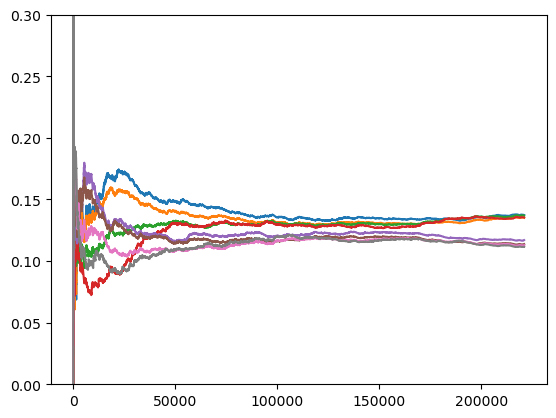

In [15]:
res_all_traj_indexed[1][1].shape
conform_num = 8
conform_p = calculate_conform_p(res_all_traj_indexed[1][1], conform_num)

plt.plot(conform_p.T)
plt.ylim(0, 0.3)

In [16]:
res_num = res_all_traj_indexed.shape[0]
ntraj = res_all_traj_indexed.shape[1]
conform_num = 8

all_conform_populations = []

for res in range(res_num):
    res_conform_populations = []
    for i in range(ntraj):
        traj = res_all_traj_indexed[res][i]
        conform_p = calculate_conform_p(traj, conform_num)
        res_conform_populations.append(conform_p)
    all_conform_populations.append(res_conform_populations)

# Find the longest trajectory (in terms of time steps)
maxlength = max([all_conform_populations[0][i].shape[1] for i in range(ntraj)])
print('maxlength', maxlength)

# Make an array to store all the conformational populations with padding
all_conform_p = np.full((res_num, ntraj, conform_num, maxlength), np.nan) #(3, 94, 8, x)

for res in range(res_num):
    for i in range(ntraj):
        conform_p = all_conform_populations[res][i]
        time_len = conform_p.shape[1]
        all_conform_p[res, i, :, :time_len] = conform_p
    print('all_conform_p.shape', all_conform_p.shape)


all_thermal_conform_mean = np.nanmean(all_conform_p, axis=1)
all_thermal_conform_std = np.nanstd(all_conform_p, axis=1)
all_thermal_conform_mean.shape

maxlength 318010
all_conform_p.shape (3, 100, 8, 318010)
all_conform_p.shape (3, 100, 8, 318010)
all_conform_p.shape (3, 100, 8, 318010)


(3, 8, 318010)

In [17]:
all_conform_p.shape

(3, 100, 8, 318010)

In [18]:
## Reshape the traj into (res_num, thermal_num, conform_num, time) (3, 4, 2, x)

thermal_num = 4
conform_num = 2 # cis and trans 
cis_Ind = np.arange(0, 8, 4)
res_num = all_thermal_conform_mean.shape[0]
time_len = all_thermal_conform_mean.shape[2] 
ntraj = all_conform_p.shape[1]

# Preallocate arrays
reshaped_mean = np.full((res_num, thermal_num, conform_num, time_len), np.nan) #(3, 4, 2, x)
reshaped_std = np.full((res_num, thermal_num, conform_num, time_len), np.nan) #(3, 4, 2, x)
reshaped_all_conform = np.full((res_num, ntraj, thermal_num, conform_num, time_len), np.nan) #(3, 4, 2, x)


for res in range(res_num):
    for thermal in range(thermal_num):
        reshaped_mean[res][thermal] = all_thermal_conform_mean[res][cis_Ind + thermal] #(3)(4, 2, x)
        reshaped_std[res][thermal] = all_thermal_conform_std[res][cis_Ind + thermal]

        reshaped_mean[res][thermal] /= np.nansum(reshaped_mean[res][thermal], axis=0)

for res in range(res_num):
    for i in range(ntraj):
        for thermal in range(thermal_num):
            reshaped_all_conform[res][i][thermal] = all_conform_p[res][i][cis_Ind + thermal]
            reshaped_all_conform[res][i][thermal] /= np.sum(reshaped_all_conform[res][i][thermal], axis=0)

# Normalize over conformers at each time point per thermal group
reshaped_all_conform.shape

/var/folders/d8/y2dvs1ln1gjcwccrkvtffr240000gn/T/ipykernel_18164/2688180256.py:21: RuntimeWarning: invalid value encountered in divide
  reshaped_mean[res][thermal] /= np.nansum(reshaped_mean[res][thermal], axis=0)
/var/folders/d8/y2dvs1ln1gjcwccrkvtffr240000gn/T/ipykernel_18164/2688180256.py:27: RuntimeWarning: invalid value encountered in divide
  reshaped_all_conform[res][i][thermal] /= np.sum(reshaped_all_conform[res][i][thermal], axis=0)


(3, 100, 4, 2, 318010)

In [19]:
population_result = [reshaped_mean, reshaped_std]
os.makedirs('population_data', exist_ok=True)

data_instance = Data(population_result)
data_instance.save("population_data/population_res.pkl")

In [21]:
population_result_reduced = [reshaped_mean[:, :, :, ::100], reshaped_std[:, :, :, ::100]]
os.makedirs('population_data', exist_ok=True)

data_instance = Data(population_result_reduced)
data_instance.save("population_data/population_res_reduced.pkl")

## Plot for each Res

In [22]:
mean = reshaped_mean[res, thermal, 1,  :]
time = np.arange(reshaped_mean.shape[3]) #(3, 4, 2, x)
time.shape
mean.shape

(318010,)

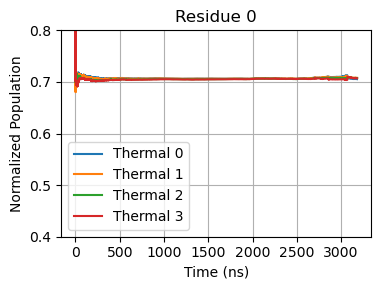

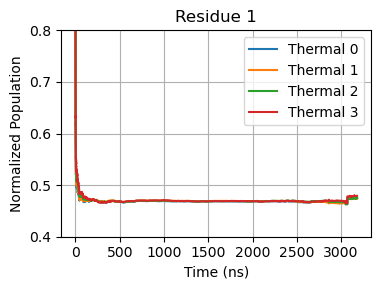

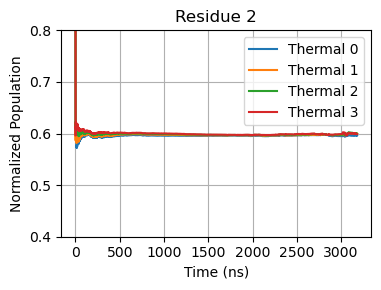

In [23]:
dt_in_ns = 0.01  # 10 ps = 0.01 ns
thermal_num = 4
time = np.arange(reshaped_mean.shape[3]) #(3, 4, 2, x)
time_ns = time * dt_in_ns  # Convert to ns

for res in range(res_num):
    plt.figure(figsize=(4, 3))
    for thermal in range(thermal_num):
        mean = reshaped_mean[res, thermal, 1,  :] # Only plot trans 
        rmsd = reshaped_std[res, thermal, 1,  :] # Only plot trans 

        # Plot mean line
        plt.plot(time_ns, mean, label=f'Thermal {thermal}')
        # Plot shaded region using time_ns
        #plt.fill_between(time_ns, mean - rmsd, mean + rmsd, alpha=0.3)

    plt.ylim(0.4, 0.8)
    plt.xlabel("Time (ns)")
    plt.ylabel("Normalized Population")
    plt.title(f"Residue {res}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Error each thermal state

In [24]:
## Load in the refer values calculated by MSM

df_stationary_p = pd.read_csv("autocoorel_data/trans_population_at_lagtime.csv")
#print(df_stationary_p)
    
# Pivot the DataFrame to reshape it
pivot_mean = df_stationary_p.pivot(index='state', columns='res', values='mean')
pivot_std = df_stationary_p.pivot(index='state', columns='res', values='std')

# Convert to NumPy arrays
trans_refer = pivot_mean.to_numpy()  # shape (6, 3) state, residues 
trans_refer_err = pivot_std.to_numpy()  # shape (6, 3)
trans_refer[0]

array([0.70641338, 0.46809611, 0.59630045])

In [25]:
reshaped_all_conform.shape
reshaped_trans_p_state0 = reshaped_all_conform[:, :, 0, 1, :]
reshaped_trans_p_state0.shape ## (res, ntraj, times)

(3, 100, 318010)

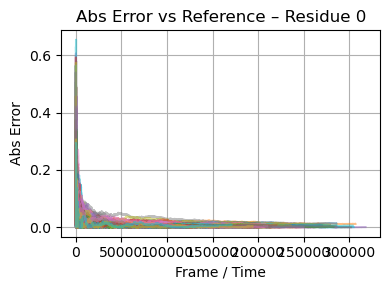

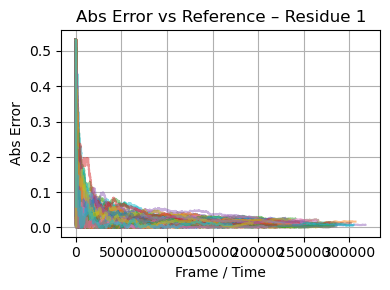

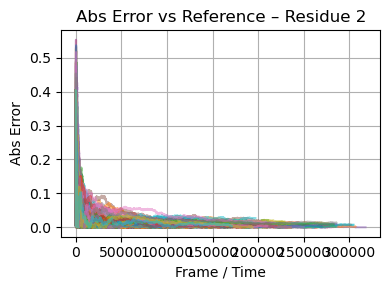

In [26]:
res_num = 3

for res in range(res_num):
    plt.figure(figsize=(4, 3))
    res_trajs = reshaped_trans_p_state0[res]

    for i in range(len(res_trajs)):
        traj = res_trajs[i]  # shape: (time,)
        errors = np.abs(traj - trans_refer[0][res])  # reference is a scalar
        plt.plot(errors, alpha=0.5)

    plt.title(f'Abs Error vs Reference – Residue {res}')
    plt.xlabel('Frame / Time')
    plt.ylabel('Abs Error')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


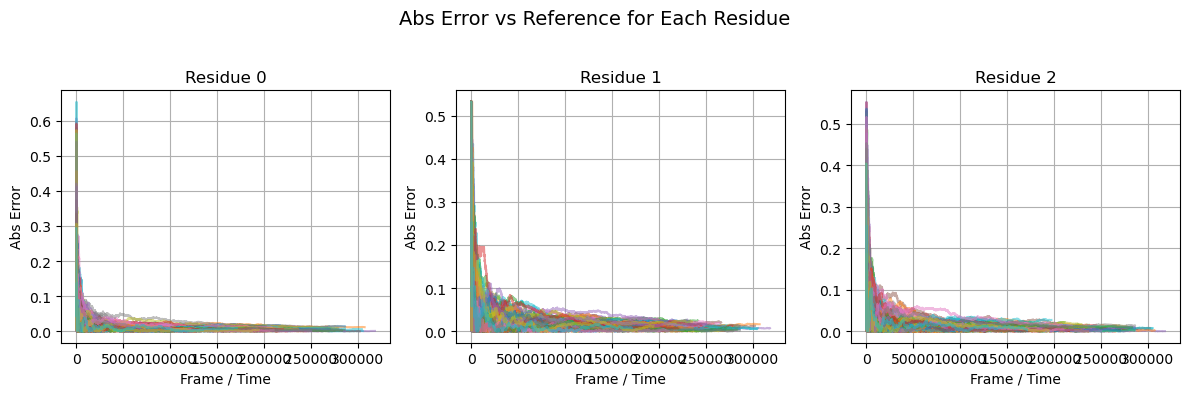

In [27]:
import matplotlib.pyplot as plt

res_num = 3
fig, axs = plt.subplots(1, res_num, figsize=(12, 4))  # 1 row, 3 columns

for res in range(res_num):
    ax = axs[res]
    res_trajs = reshaped_trans_p_state0[res]

    for i in range(len(res_trajs)):
        traj = res_trajs[i]  # shape: (time,)
        errors = np.abs(traj - trans_refer[0][res])  # scalar reference
        ax.plot(errors, alpha=0.5)

    ax.set_title(f'Residue {res}')
    ax.set_xlabel('Frame / Time')
    ax.set_ylabel('Abs Error')
    ax.grid(True)

fig.suptitle('Abs Error vs Reference for Each Residue', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
plt.show()


## RMSD Over time 

In [29]:
reshaped_all_conform.shape
reshaped_trans_p_state0 = reshaped_all_conform[:, :, 0, 1, :]
reshaped_trans_p_state0.shape ## (res, ntraj, times)

(3, 100, 318010)

In [30]:
ntraj = reshaped_trans_p_state0.shape[1]
res_num = 3

ref = trans_refer[0].reshape(3, 1, 1)

errors = np.abs(reshaped_trans_p_state0 - ref) ** 2 
#print(errors.shape)
rmsd = np.sqrt(np.nansum(errors, axis=1) / errors.shape[1])
rmsd.shape

(3, 318010)

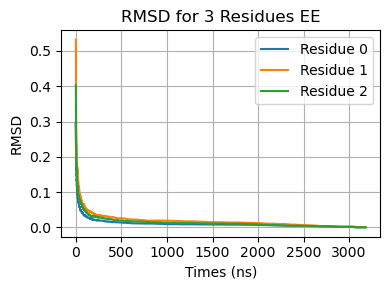

In [31]:
dt_in_ns = 0.01
times = np.arange(rmsd.shape[1]) * dt_in_ns

plt.figure(figsize=(4, 3))
for i in range(res_num):
    plt.plot(times, rmsd[i], label=f'Residue {i}')
plt.title("RMSD for 3 Residues EE")
plt.xlabel("Times (ns)")
plt.ylabel("RMSD")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [29]:
errors_result = [rmsd]

os.makedirs('population_data', exist_ok=True)

data_instance = Data(errors_result)
data_instance.save("population_data/error_res.pkl")

In [32]:
errors_result_reduced = [rmsd[:, ::100]]

os.makedirs('population_data', exist_ok=True)

data_instance = Data(errors_result_reduced)
data_instance.save("population_data/error_res_reduced.pkl")

## Conformation over time against stationary populaiton

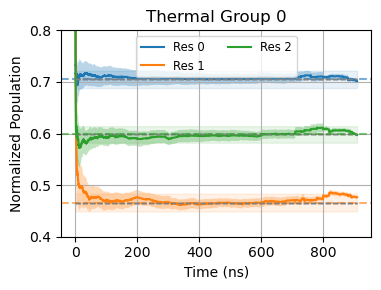

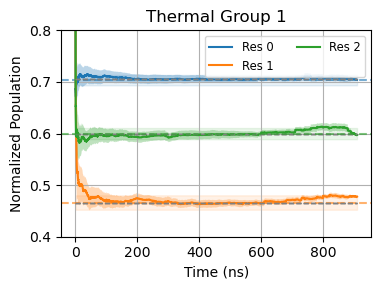

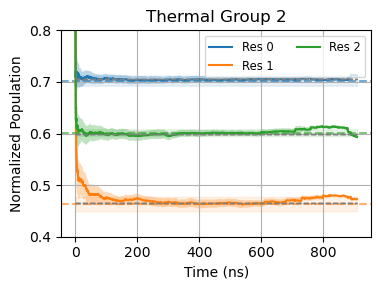

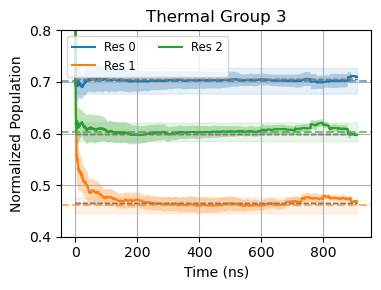

In [30]:
dt_in_ns = 0.01  # 10 ps = 0.01 ns
time = np.arange(reshaped_mean.shape[3]) #(3, 4, 2, x)
time_ns = time * dt_in_ns  # Convert to ns

for thermal in range(thermal_num):
    plt.figure(figsize=(4, 3))

    for res in range(res_num):
        mean = reshaped_mean[res, thermal, 1,  :] # Only plot trans 
        rmsd = reshaped_std[res, thermal, 1,  :] # Only plot trans 

        plt.plot(time_ns, mean, label=f'Res {res}')
        plt.fill_between(time_ns, mean - rmsd, mean + rmsd, alpha=0.3)
        plt.hlines(y=ref, xmin=time_ns[0], xmax=time_ns[-1],
                   colors='gray', linestyles='--', linewidth=1)

        # Reference horizontal line
        ref_y = trans_refer[thermal, res]
        ref_yerr = trans_refer_err[thermal, res]

        plt.axhline(y=ref_y, linestyle='--', color=f'C{res}', alpha=0.6)
        plt.fill_between(time_ns, ref_y - ref_yerr, ref_y + ref_yerr, color=f'C{res}', alpha=0.1)
    # Optional: set y-axis limits if you want consistency across plots
    plt.ylim(0.4, 0.8)

    plt.xlabel("Time (ns)")
    plt.ylabel("Normalized Population")
    plt.title(f"Thermal Group {thermal}")
    plt.legend(ncol=2, fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


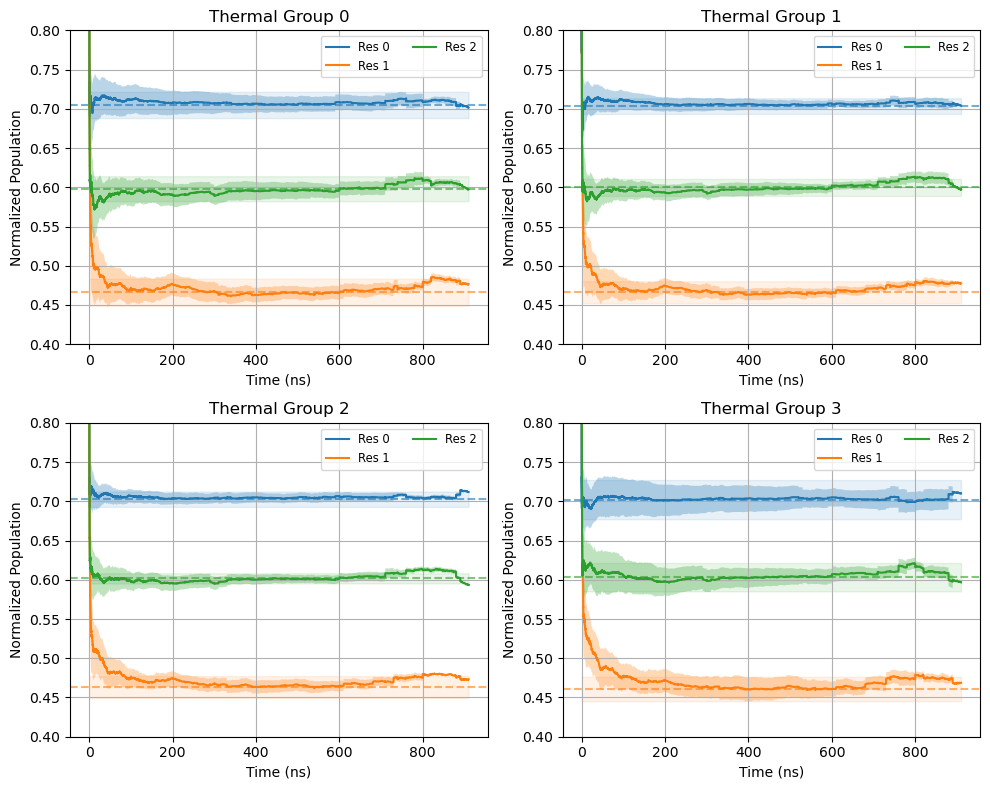

In [31]:
dt_in_ns = 0.01  # 10 ps = 0.01 ns
time = np.arange(reshaped_mean.shape[3])
time_ns = time * dt_in_ns  # Convert to ns

fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # 2x2 grid
axs = axs.flatten()

for idx, thermal in enumerate(range(4)):  # Only first 4 thermal groups
    ax = axs[idx]
    
    for res in range(res_num):
        mean = reshaped_mean[res, thermal, 1, :]  # Only trans
        rmsd = reshaped_std[res, thermal, 1, :]   # Only trans

        ax.plot(time_ns, mean, label=f'Res {res}')
        ax.fill_between(time_ns, mean - rmsd, mean + rmsd, alpha=0.3)

        ref_y = trans_refer[thermal, res]
        ref_yerr = trans_refer_err[thermal, res]

        ax.axhline(y=ref_y, linestyle='--', color=f'C{res}', alpha=0.6)
        ax.fill_between(time_ns, ref_y - ref_yerr, ref_y + ref_yerr, color=f'C{res}', alpha=0.1)

    ax.set_ylim(0.4, 0.8)
    ax.set_xlabel("Time (ns)")
    ax.set_ylabel("Normalized Population")
    ax.set_title(f"Thermal Group {thermal}")
    ax.grid(True)
    ax.legend(ncol=2, fontsize='small')

plt.tight_layout()
plt.show()
